# Setup

In [1]:
%%capture
!pip install transformers[torch]

In [2]:
import os
import copy
import random

import torch
import numpy as np
import pandas as pd
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from torch import nn

from transformers import AutoTokenizer, AutoModel, AutoModelForSeq2SeqLM
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainingArguments, Trainer
from transformers import TrainingArguments, Trainer
from transformers import TrainerCallback

In [3]:
def set_css():
    """
    Function to wrap cell outputs
    """
    from IPython.display import HTML, display

    display(HTML('''
    <style>
        pre {
            white-space: pre-wrap;
        }
    </style>
    '''))

    return

get_ipython().events.register('pre_run_cell', set_css)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [5]:
# change to project directory
project_folder = 'drive/MyDrive/Datasci266/w266_project/'

if not os.getcwd().endswith('w266_project'):
    os.chdir(project_folder)

test_articles = pd.read_pickle("data/author_abstracts.pkl")

# load pickle file
author_data = pd.read_pickle("data/ft_articles.pkl")

# remove rows in author_data where there is a match on the "link" column in test_articles
print(len(author_data))
author_data = author_data[~author_data['link'].isin(test_articles['link'])]
author_data.reset_index(drop=True, inplace=True)
print(len(author_data))

author_data = author_data[['title', 'abstract']]
author_data.tail(2)

3241
3231


,title,abstract
3229,Characterization of the apicomplexan amino aci...,Apicomplexan parasites are auxotrophic for a r...
3230,Interneuronal mechanisms of hippocampal theta ...,The hippocampal theta rhythm plays important r...


In [6]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

In [7]:
# --- load BART model --- #

def initialize_bart(
        model_to_init='base_model',
        mlm_path="states/mlm_model_state",
        ft_mlm_path="states/ft_mlm_model_state",
        ft_only_path="states/ft_only_model_state",
    ):

    if model_to_init == 'base_model':
        out_model = BartForConditionalGeneration.from_pretrained(
            "facebook/bart-large-cnn"
        )

    elif model_to_init == 'mlm_model':
        out_model = BartForConditionalGeneration.from_pretrained(
            mlm_path
        )

    elif model_to_init == 'ft_mlm_model':
        out_model = BartForConditionalGeneration.from_pretrained(
            ft_mlm_path
        )

    elif model_to_init == 'ft_only_model':
        out_model = BartForConditionalGeneration.from_pretrained(
            ft_only_path
        )

    else:
        out_model = None

    return out_model

try:
    base_model
except:
    base_model = initialize_bart(
        'base_model'
    )


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [8]:
base_model.device

device(type='cpu')

# Prepare training, validation datasets

In [9]:
# prepare training and validation datasets

def prepare_data(data):
    """
    Prepares data for training by tokenizing and adding special tokens.
    """
    inputs = tokenizer(data["abstract"], truncation=True, max_length=512, padding="max_length")
    labels = tokenizer(data["title"], truncation=True, max_length=128, padding="max_length")

    # add special tokens for BART
    # inputs["input_ids"] = [tokenizer.cls_token_id + ids + tokenizer.sep_token_id for ids in inputs["input_ids"]]
    # labels["input_ids"] = [ids + tokenizer.eos_token_id for ids in labels["input_ids"]]

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels["input_ids"],
    }

train_data = author_data.sample(frac=0.8, random_state=42).reset_index(drop=True)
val_data = author_data.drop(train_data.index).reset_index(drop=True)

train_dataset = train_data.apply(prepare_data, axis=1)
val_dataset = val_data.apply(prepare_data, axis=1)

In [10]:
len(train_dataset), len(val_dataset)

(2585, 646)

# Fine Tuning BART Models

In [ ]:
# class LossLoggerCallback(TrainerCallback):
#     def on_epoch_end(self, args, state, control, **kwargs):
#         if state.epoch is not None:
#             last_metrics = state.log_history[-1]
#             print_keys=True
#             if print_keys:
#                 print(last_metrics.keys())
#                 print_keys=False
#             print(f"Epoch {state.epoch} - Training Loss: {last_metrics['loss']}")

def finetune_bart_summarization(
        untuned_model,
        train_dataset,
        val_dataset,
        out_name,
        evaluation_steps = 400,
        out_metadata='./outputs',
    ):

    # initalize DataCollator for batching
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=untuned_model
    )

    # specify arguments for trainer class
    training_args = Seq2SeqTrainingArguments(
        out_metadata,
        evaluation_strategy='steps',
        save_strategy='epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=2,
        weight_decay=0.01,
        save_total_limit=2,
        num_train_epochs=3,
        predict_with_generate=True,
        eval_accumulation_steps=3,
        fp16=True, # available only with cuda
        logging_steps=100,
        eval_steps=evaluation_steps,
    )

    # initialize Trainer class
    trainer = Trainer(
        model=untuned_model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        # callbacks=[LossLoggerCallback()]
    )

    # start training
    trainer.train()

    # save the fine-tuned model
    untuned_model.save_pretrained(
        "states/"+out_name
    )

    train_metrics = trainer.evaluate(train_dataset)
    val_metrics = trainer.evaluate(val_dataset)

    return train_metrics, val_metrics

## Fine Tune BART Model with Additional MLM Pretraining

See BART_MLM_Continued_Pretraining.ipynb for the code to generate the model we load in this section

In [ ]:
run_finetuning_on_mlm = False
load_mlm_checkpoint = True
# mlm_checkpoint_path = 'states/mlm_state_checkpoints/'
# mlm_checkpoint_fname = '5_model_state'
mlm_checkpoint_path = 'states/'
mlm_checkpoint_fname = 'ft_mlm_model_state_3e'

if run_finetuning_on_mlm:

    if load_mlm_checkpoint:
        print(f'Loading checkpoint: {mlm_checkpoint_fname}')
        mlm_model = initialize_bart(
            'mlm_model',
            mlm_checkpoint_path+mlm_checkpoint_fname,

        )
    else:
        print('Loading default checkpoint.')
        mlm_model = initialize_bart(
            'mlm_model',
        )

    print(type(mlm_model),'\n\n')

    mlm_train_metrics, mlm_val_metrics = finetune_bart_summarization(
        mlm_model,
        train_dataset,
        val_dataset,
        out_name="ft_mlm_model_state",
        out_metadata='./outputs_mlm'
    )

Loading checkpoint: ft_mlm_model_state_3e
<class 'transformers.models.bart.modeling_bart.BartForConditionalGeneration'> 




/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
400,0.273500,0.303746
800,0.257600,0.280645
1200,0.272000,0.264551
1600,0.256700,0.254165


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

In [ ]:
display(mlm_train_metrics)
display(mlm_val_metrics)

{'eval_loss': 0.21230261027812958,
 'eval_runtime': 37.3033,
 'eval_samples_per_second': 69.297,
 'eval_steps_per_second': 34.662,
 'epoch': 3.0}

{'eval_loss': 0.24921557307243347,
 'eval_runtime': 8.2953,
 'eval_samples_per_second': 77.875,
 'eval_steps_per_second': 38.938,
 'epoch': 3.0}

In [ ]:
e3 = 1938 # total # of steps to complete 3 epochs
e6 = e3*2 # total # of steps to complete 6 epochs

mlm_ft_3e = {
    'Step': [
        400, 800, 1200, 1600, e3, # first run, 3 epochs
        e3+400, e3+800, e3+1200, e3+1600, e6, # 3 additional epochs
    ],
    'Training Loss': [
        0.475800, 0.405400, 0.382600, 0.344200, 0.285546,
        0.273500, 0.257600, 0.272000, 0.256700, 0.212303,

    ],
    'Validation Loss': [
        0.394328, 0.345759, 0.323855, 0.311243, 0.305732,
        0.303746, 0.280645, 0.264551, 0.254165, 0.249216,
    ]
}

# mlm_ft_3e = pd.DataFrame(mlm_ft_3e)
# mlm_ft_3e.to_pickle('data/fine_tuning/mlm_3_epochs.pkl')

## Fine Tuning Base BART Model

In [ ]:
run_finetuning_on_base = False
continue_base_finetuning = False

fto_checkpoint_path = 'states/'
fto_checkpoint_fname = 'ft_only_model_state_3e'

if run_finetuning_on_base:
    ft_train_metrics, ft_val_metrics = finetune_bart_summarization(
        base_model,
        train_dataset,
        val_dataset,
        out_name="ft_only_model_state",
        out_metadata='./outputs_base'
    )

if continue_base_finetuning:
    continue_fto_model = initialize_bart(
        'ft_only_model',
        ft_only_path=fto_checkpoint_path+fto_checkpoint_fname,
    )

    ft_train_metrics, ft_val_metrics = finetune_bart_summarization(
        continue_fto_model,
        train_dataset,
        val_dataset,
        out_name="ft_only_model_state",
        out_metadata='./outputs_base'
    )


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
400,0.058000,0.218628
800,0.033300,0.207922
1200,0.040200,0.216058
1600,0.028600,0.196798


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

In [ ]:
display(ft_train_metrics)
display(ft_val_metrics)

{'eval_loss': 0.06583144515752792,
 'eval_runtime': 82.6804,
 'eval_samples_per_second': 31.265,
 'eval_steps_per_second': 15.639,
 'epoch': 3.0}

{'eval_loss': 0.17509770393371582,
 'eval_runtime': 17.9926,
 'eval_samples_per_second': 35.904,
 'eval_steps_per_second': 17.952,
 'epoch': 3.0}

In [ ]:
# note to add e6 values
# train: 0.065831
# val: 0.175098

base_ft_3e = {
    'Step': [
        400, 800, 1200, 1600, e3,
        e3+400, e3+800, e3+1200, e3+1600, e6,
    ],
    'Training Loss': [
        0.171800, 0.102600, 0.117800, 0.092000, 0.083237,
        0.058000, 0.033300, 0.040200, 0.028600, 0.065831,

    ],
    'Validation Loss': [
        0.227889, 0.211860, 0.191399, 0.171461, 0.162092,
        0.218628, 0.207922, 0.216058, 0.196798, 0.175098,

    ],
}

# base_ft_3e = pd.DataFrame(base_ft_3e)
# base_ft_3e.to_pickle('data/fine_tuning/base_ft_3_epochs.pkl')

## Loss graphs

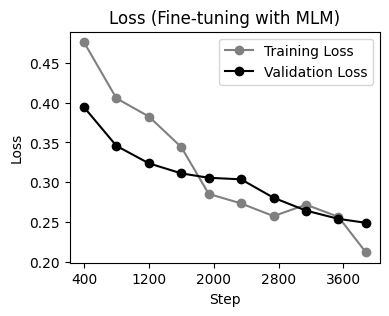

In [ ]:
loss_history_ft_mlm = pd.read_pickle('data/fine_tuning/mlm_3_epochs.pkl')

plt.figure(figsize=(4, 3))

# training line
plt.plot(
    loss_history_ft_mlm['Step'],
    loss_history_ft_mlm['Training Loss'],
    label='Training Loss',
    marker='o',
    color='grey'
)

# validation line
plt.plot(
    loss_history_ft_mlm['Step'],
    loss_history_ft_mlm['Validation Loss'],
    label='Validation Loss',
    marker='o',
    color='black'
)

# x-axis ticks
plt.xticks(range(400, loss_history_ft_mlm['Step'].max() + 1, 800))

plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss (Fine-tuning with MLM)')
plt.legend()
plt.show()


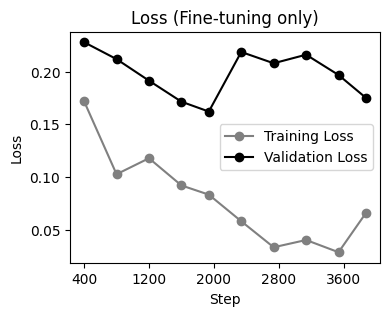

In [ ]:

loss_history_ft_only = pd.read_pickle('data/fine_tuning/base_ft_3_epochs.pkl')

plt.figure(figsize=(4, 3))
plt.plot(
    loss_history_ft_only['Step'],
    loss_history_ft_only['Training Loss'],
    label='Training Loss',
    marker='o',
    color='grey',
)
plt.plot(
    loss_history_ft_only['Step'],
    loss_history_ft_only['Validation Loss'],
    label='Validation Loss',
    marker='o',
    color='black'
)

# x-axis ticks
plt.xticks(range(400, loss_history_ft_mlm['Step'].max() + 1, 800))

# Add labels and title
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss (Fine-tuning only)')
plt.legend()
plt.show()

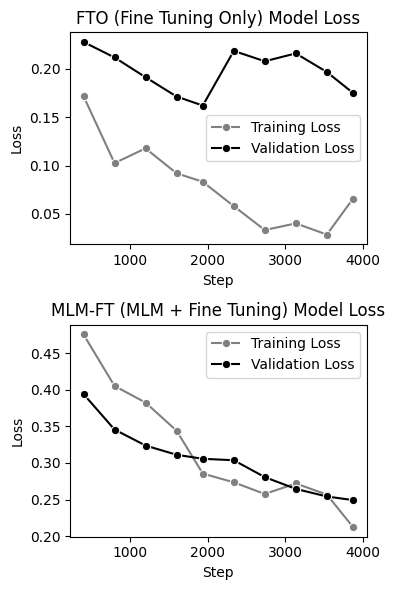

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6))

# fine tuning only
sns.lineplot(data=loss_history_ft_only, x='Step', y='Training Loss', label='Training Loss', color='grey', marker='o', ax=axs[0])
sns.lineplot(data=loss_history_ft_only, x='Step', y='Validation Loss', label='Validation Loss', color='black', marker='o', ax=axs[0])
axs[0].set_title('FTO (Fine Tuning Only) Model Loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Step')
axs[0].legend()

# fine tuning with MLM
sns.lineplot(data=loss_history_ft_mlm, x='Step', y='Training Loss', label='Training Loss', color='grey', marker='o', ax=axs[1])
sns.lineplot(data=loss_history_ft_mlm, x='Step', y='Validation Loss', label='Validation Loss', color='black', marker='o', ax=axs[1])
axs[1].set_title('MLM-FT (MLM + Fine Tuning) Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Step')
axs[1].legend()

plt.tight_layout()
plt.show()

# Load checkpoints for summarization

In [10]:
ft_mlm_checkpoint_path = 'states/'

ft_mlm_checkpoint_fname = 'ft_mlm_model_state'
ft_mlm_3e_model = initialize_bart(
    'ft_mlm_model',
    ft_mlm_path=ft_mlm_checkpoint_path + ft_mlm_checkpoint_fname
    # this is the 3 epoch checkpoint
)

ft_mlm_checkpoint_fname = 'ft_mlm_model_state_6e'
ft_mlm_6e_model = initialize_bart(
    'ft_mlm_model',
    ft_mlm_path=ft_mlm_checkpoint_path + ft_mlm_checkpoint_fname
    # this is the 6 epoch checkpoint
)

fto_checkpoint_path = 'states/'
fto_checkpoint_fname = 'ft_only_model_state_3e'

ft_only_model = initialize_bart(
    'ft_only_model',
    ft_only_path=fto_checkpoint_path + fto_checkpoint_fname
    # this is the 3 epoch checkpoint
)

In [ ]:
# --- send base model to cpu  --- #

if base_model.device.type == 'cpu':
    pass
elif base_model.device.type == 'cuda':
    print('Moving model from GPU to CPU')
    base_model.to('cpu')
else:
    print('Unkown device')

# Generate Summaries

In [15]:
assert False

AssertionError: 

In [11]:
show_tests = False

In [52]:
def summarize_abstract(
    model,
    tokenizer,
    input_text,
    metadata,
    ):

    # # add a prompt
    # prompt = "Summarize the following text in one sentence: "
    # input_text = prompt + input_text

    # Tokenize the input text
    input_ids = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=1024,
        truncation=True,
    )

    # Generate summary using BART
    summary_ids = model.generate(
        input_ids["input_ids"],
        do_sample=True,
        num_beams=metadata['num_beams'],
        no_repeat_ngram_size=metadata['no_repeat_ngram_size'],
        length_penalty=metadata['length_penalty'],
        max_length=metadata['max_length'],
        min_length=metadata['min_length'],
        temperature=metadata['temperature'],
        early_stopping=True
    )

    # Decode the generated summary
    summary = tokenizer.decode(
        summary_ids[0],
        skip_special_tokens=True
    )

    return summary

def execute_summartization(
        articles,
        models_for_summarization,
        previous_summaries=None,
        metadata={
            'num_beams': 4,
            'no_repeat_ngram_size': 3,
            'length_penalty': 2.0,
            'max_length': 125,
            'min_length': 22,
            'temperature': 1,
        }
    ):

    if isinstance(previous_summaries, pd.DataFrame):
        run_num = max(previous_summaries['run'])+1
    else:
        run_num = 1

    df_summaries = articles[['title', 'abstract']].copy()

    for key, model in models_for_summarization.items():
        print('Starting summarization for:', key)
        df_summaries[key] = df_summaries['abstract'].apply(
            lambda abstract: summarize_abstract(
                model,
                tokenizer,
                abstract,
                metadata,
            )
        )

    df_summaries['id'] = df_summaries.index
    df_summaries['run'] = run_num
    df_summaries['metadata'] = str(metadata)

    return df_summaries

In [63]:
base_metadata={
    'num_beams': 4,
    'no_repeat_ngram_size': 3,
    'length_penalty': 2.0,
    'max_length': 125,
    'min_length': 22,
    'temperature': 1,
}

In [13]:
test_title = test_articles['title'][0]
test_abstract = test_articles['abstract'][0]
print(
    'Title: \n',
    test_title,
    '\n\n',
    'Abstract: \n',
    test_abstract,
    sep=''
)

Title: 
Biophysical modeling of frontocentral ERP generation links circuit-level mechanisms of action-stopping to a behavioral race model

Abstract: 
Human frontocentral event-related potentials (FC-ERPs) are ubiquitous neural correlates of cognition and control, but their generating multiscale mechanisms remain mostly unknown. We used the Human Neocortical Neurosolver(HNN)’s biophysical model of a canonical neocortical circuit under exogenous thalamic and cortical drive to simulate the cell and circuit mechanisms underpinning the P2, N2, and P3 features of the FC-ERP observed after Stop-Signals in the Stop-Signal task (SST). We demonstrate that a sequence of simulated external thalamocortical and cortico-cortical drives can produce the FC-ERP, similar to what has been shown for primary sensory cortices. We used this model of the FC-ERP to examine likely circuit-mechanisms underlying FC-ERP features that distinguish between successful and failed action-stopping. We also tested their ad

In [35]:
# get max and min token length from test_articles

def min_max_token_length(test_articles):
    max_token_length = max([len(tokenizer(abstract)['input_ids']) for abstract in test_articles['title']])
    min_token_length = min([len(tokenizer(abstract)['input_ids']) for abstract in test_articles['title']])

    percentile_75 = np.percentile([len(tokenizer(abstract)['input_ids']) for abstract in test_articles['title']], 75)
    percentile_25 = np.percentile([len(tokenizer(abstract)['input_ids']) for abstract in test_articles['title']], 25)
    return min_token_length, max_token_length, percentile_75, percentile_25

min_max_token_length(
    test_articles=test_articles
)

(13, 33, 22.0, 17.5)

In [ ]:
# --- Base Model --- #
if show_tests:
    summarize_abstract(
        base_model,
        tokenizer,
        test_abstract,
    )

In [16]:
# --- Fine-Tuned Model --- #
if show_tests:
    summarize_abstract(
        ft_only_model,
        tokenizer,
        test_abstract,
    )

In [17]:
# --- Pretrained and Fine-Tuned Model --- #
if show_tests:
    summarize_abstract(
        ft_mlm_3e_model,
        tokenizer,
        test_abstract,
    )

In [29]:
# --- show 'generation' configuration

models_for_summarization = {
    'base_bart_model': base_model,
    'finetuned_model': ft_only_model,
    'mlm_ft_3e_model': ft_mlm_3e_model,
    'mlm_ft_6e_model': ft_mlm_6e_model,
}

for model_name, model in models_for_summarization.items():
    print(
        model.generation_config
    )

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "length_penalty": 2.0,
  "max_length": 142,
  "min_length": 56,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_toke

# View Previous Outputs

In [32]:
old_summaries = pd.read_pickle('data/all_summaries.pkl')
print('Previous runs:',list(set(old_summaries['run'])))

Previous runs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [33]:
isolated_summaries = pd.read_pickle('data/isolated_summaries.pkl')
isolated_summaries.tail(2)

,title,abstract,mlm_ft_6e_model,id,run
14,The rate of transient beta frequency events pr...,Beta frequency oscillations (15-29Hz) are amon...,Temporally relevant differences in averaged pr...,14,2
15,Membrane state diagrams make electrophysiologi...,Ion channels are ubiquitous in living systems....,Modeling the membrane differential equation ce...,15,2


# Run Output Generation Loop

In [25]:
# --- fxn to mange saving outputs --- #

def save_new_summaries(
        new_summaries,
        previous_summaries,
        out_directory='data/all_summaries.pkl',
    ):

    current_run_num = max(new_summaries['run'])

    if not current_run_num in set(previous_summaries['run']):
        print('Saving new summaries')
        previous_summaries = pd.concat([previous_summaries, new_summaries])
        previous_summaries.to_pickle(out_directory)
    else:
        print('No new summaries to save')

    return previous_summaries

# --- fxn to manage seeds --- #

loop_seed = 8

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [61]:
# --- Loop specifications --- #

num_runs = 5
out_directory = 'data/isolated_summaries.pkl'

previous_runs = pd.read_pickle(out_directory)
# previous_runs = None

models_for_summarization = {
    'base_bart_model': base_model,
    'finetuned_model': ft_only_model,
    'mlm_ft_3e_model': ft_mlm_3e_model,
    'mlm_ft_6e_model': ft_mlm_6e_model,
}

run_metadata={
    'num_beams': 4,
    'no_repeat_ngram_size': 3,
    'length_penalty': 2.0,
    'max_length': 50,
    'min_length': 22,
    'temperature': 1.1,
}

if isinstance(previous_runs, pd.DataFrame):
    print('Continuing from previous file ...')
    print('Saving run outputs to:', out_directory)
else:
    print('Re-writing file.')
    print('Saving run outputs to:', out_directory)
print(f'Executing {num_runs} runs')


Continuing from previous file ...
Saving run outputs to: data/isolated_summaries.pkl
Executing 5 runs


In [62]:
for run in range(0, num_runs):
    # setup
    start_time = time.time()
    set_seed(loop_seed)

    # summarization
    print('Current run:', run+1, 'of', num_runs)
    test_article_summaries = execute_summartization(
        test_articles,
        models_for_summarization,
        previous_runs,
        run_metadata,
    )

    # if resetting runs, save to file
    if not isinstance(previous_runs, pd.DataFrame):
        print(f'Saving first run to {out_directory}')
        previous_runs = test_article_summaries
        previous_runs.to_pickle(out_directory)

    # save additional runs to previous files if applicable
    previous_runs = save_new_summaries(
        test_article_summaries,
        previous_runs,
        out_directory=out_directory,
    )

    loop_seed += 1
    end_time = time.time()

    # prints for tracking progress
    print('Total record count:',len(previous_runs))
    print('-'*50)
    print('Time elapsed:', round((end_time - start_time)/60, 2),'minutes')
    print('-'*50)


Current run: 1 of 5
Starting summarization for: base_bart_model
Starting summarization for: finetuned_model
Starting summarization for: mlm_ft_3e_model
Starting summarization for: mlm_ft_6e_model
Saving new summaries
Total record count: 336
--------------------------------------------------
Time elapsed: 9.66 minutes
--------------------------------------------------
Current run: 2 of 5
Starting summarization for: base_bart_model
Starting summarization for: finetuned_model
Starting summarization for: mlm_ft_3e_model
Starting summarization for: mlm_ft_6e_model
Saving new summaries
Total record count: 352
--------------------------------------------------
Time elapsed: 9.29 minutes
--------------------------------------------------
Current run: 3 of 5
Starting summarization for: base_bart_model
Starting summarization for: finetuned_model
Starting summarization for: mlm_ft_3e_model
Starting summarization for: mlm_ft_6e_model
Saving new summaries
Total record count: 368
-------------------

In [ ]:
# --- single run --- #

single_run = False
save_summaries = True

if single_run:

    test_article_summaries = execute_summartization(
        test_articles,
        models_for_summarization,
        old_summaries,
    )

    if save_summaries:
        old_summaries = save_new_summaries(
            test_article_summaries,
            old_summaries,
        )

    test_article_summaries.tail(2)

# Extra

In [37]:
merge_cols = ['id', 'run', 'mlm_ft_6e_model']

old_summaries = pd.read_pickle('data/all_summaries.pkl')
isolated_summaries = pd.read_pickle('data/isolated_summaries.pkl')

# merge old and isolated summaries
joined = pd.merge(
    old_summaries,
    isolated_summaries[merge_cols],
    on=['id', 'run'],
)

joined.columns
joined=joined[[
    'id', 'run', 'title', 'abstract', 'base_bart_model',
    'finetuned_model','mlm_and_finetuned_model','mlm_ft_6_epoch'
]]

joined.rename(columns={
     'mlm_and_finetuned_model':'mlm_ft_3e_model',
     'mlm_ft_6_epoch':'mlm_ft_6e_model',
 })

In [18]:
old_summaries.rename(columns={'mlm_and_finetuned_model':'mlm_ft_3e_model'}, inplace=True
)
old_summaries

,id,run,title,abstract,base_bart_model,finetuned_model,mlm_ft_3e_model,mlm_ft_6_epoch
0,0,1,Biophysical modeling of frontocentral ERP gene...,Human frontocentral event-related potentials (...,Frontocentral event-related potential (FC-ERP)...,Cellular and circuit mechanisms of the frontoc...,A biophysical model of the human frontocentral...,A biophysical model of frontocentral event-rel...
1,1,1,Distinct neocortical mechanisms underlie human...,Magneto- and/or electro-encephalography (M/EEG...,Magneto- and/or electro-encephalography (M/EEG...,Neurophysiological Mechanisms of Stereotypic m...,Neurophysiology of somatosensory cortex evoked...,Neurophysiological Mechanisms of Electro-encep...
2,2,1,Methods and considerations for estimating para...,Biophysically detailed neural models are a pow...,Biophysically detailed neural models are a pow...,Using simulation based inference to estimate t...,Simulation based inference to estimate time se...,Simulation based inference (SBI) for large sca...
3,3,1,Biophysical and Architectural Mechanisms of Su...,The cortico-basal ganglia circuit is needed to...,Cortico-basal ganglia circuit is needed to sup...,Biophysical and Architectural Dynamics of Spik...,Spiking and theta band power during response c...,Subthalamic nucleus-subthalamic network dynami...
4,4,1,Expression of soluble methane monooxygenase in...,Natural gas and biogas provide an opportunity ...,Natural gas and biogas provide an opportunity ...,Synthetic E. coli Methylococcus capsulatus sol...,Methane bioconversion in a synthetic E. coli m...,Bioconversion to acetone in a synthetic methan...
...,...,...,...,...,...,...,...,...
155,11,10,Silencing cryptic specialized metabolism in St...,Lsr2 is a nucleoid-associated protein conserve...,Lsr2 is a nucleoid-associated protein conserve...,Lsr2-mediated repression of biosynthetic clust...,"Lsr2-like, or Lsr2, is a nucleoid-associated p...","Lsr2-like, or Lsr2, is a nucleoid-associated p..."
156,12,10,Modeling mechanisms of tremor reduction for es...,Essential tremor (ET) is the most common movem...,Essential tremor (ET) is the most common movem...,Deep brain stimulation in the thalamus disrupt...,DBS disrupts tremor frequency oscillations in ...,Deep brain stimulation in the thalamus disrupt...
157,13,10,Streptomyces volatile compounds influence expl...,Bacteria and fungi produce a wide array of vol...,VOC trimethylamine (TMA) can promote a new for...,Volatile organic compounds (VOCs) have a new r...,The role of VOC trimethylamine in the modulati...,The role of VOC trimethylamine in the modulati...
158,14,10,The rate of transient beta frequency events pr...,Beta frequency oscillations (15-29Hz) are amon...,Beta frequency oscillations (15-29Hz) are amon...,Functionally relevant differences in averaged ...,Functional differences in averaged prestimulus...,Functional differences in averaged prestimulus...


In [20]:
old_summaries.to_pickle('data/all_summaries.pkl')

In [4]:
import pandas as pd
import os

project_folder = 'drive/MyDrive/Datasci266/w266_project/'
os.chdir(project_folder)

In [5]:
tmp = pd.read_pickle('data/all_summaries.pkl')
tmp.columns

Index(['id', 'run', 'title', 'abstract', 'base_bart_model', 'finetuned_model',
       'mlm_ft_3e_model', 'mlm_ft_6e_model'],
      dtype='object')

In [10]:
tmp.head(17)

,id,run,title,abstract,base_bart_model,finetuned_model,mlm_ft_3e_model,mlm_ft_6e_model
0,0,1,Biophysical modeling of frontocentral ERP gene...,Human frontocentral event-related potentials (...,Frontocentral event-related potential (FC-ERP)...,Cellular and circuit mechanisms of the frontoc...,A biophysical model of the human frontocentral...,A biophysical model of frontocentral event-rel...
1,1,1,Distinct neocortical mechanisms underlie human...,Magneto- and/or electro-encephalography (M/EEG...,Magneto- and/or electro-encephalography (M/EEG...,Neurophysiological Mechanisms of Stereotypic m...,Neurophysiology of somatosensory cortex evoked...,Neurophysiological Mechanisms of Electro-encep...
2,2,1,Methods and considerations for estimating para...,Biophysically detailed neural models are a pow...,Biophysically detailed neural models are a pow...,Using simulation based inference to estimate t...,Simulation based inference to estimate time se...,Simulation based inference (SBI) for large sca...
3,3,1,Biophysical and Architectural Mechanisms of Su...,The cortico-basal ganglia circuit is needed to...,Cortico-basal ganglia circuit is needed to sup...,Biophysical and Architectural Dynamics of Spik...,Spiking and theta band power during response c...,Subthalamic nucleus-subthalamic network dynami...
4,4,1,Expression of soluble methane monooxygenase in...,Natural gas and biogas provide an opportunity ...,Natural gas and biogas provide an opportunity ...,Synthetic E. coli Methylococcus capsulatus sol...,Methane bioconversion in a synthetic E. coli m...,Bioconversion to acetone in a synthetic methan...
5,5,1,Thalamocortical mechanisms regulating the rela...,Transient neocortical events with high spectra...,Transient neocortical events with high spectra...,Prestimulus beta event generation and suppress...,Post-event suppressive mechanisms of prestimul...,Causal mechanisms underlying prestimulus beta ...
6,6,1,Taxonomy of neural oscillation events in prima...,Electrophysiological oscillations in the brain...,Oscillation events of 1-44 cycles were present...,"Rhythmic, multi-cycle oscillation events domin...",Multi-cycle oscillation events dominate human ...,Oscillation events are multi-cycle events in h...
7,7,1,Laminar dynamics of beta bursts in human motor...,Modulation of motor cortical activity in the b...,Modulation of motor cortical activity in the b...,Laminar dynamics of beta bursts in human motor...,Laminar dynamics of motor cortical beta bursts...,Laminar dynamics of motor cortical beta bursts...
8,8,1,A supragranular nexus for the effects of neoco...,Transient neocortical events with high spectra...,Transient neocortical events with high spectra...,Somatosensory beta events suppress tactile per...,Somatosensory beta events disinhibit sensory r...,Transient thalamic bursts of spike-like bursts...
9,9,1,Human Neocortical Neurosolver (HNN): A new sof...,Magneto- and electro-encephalography (MEG/EEG)...,"Human Neocortical Neurosolver (HNN, https://hn...",Human Neocortical Neurosolver: A Graphical Use...,Human Neocortical Neurosolver (HNN): A graphic...,Human Neocortical Neurosolver: A graphical use...


In [57]:
i = 7

tmp['mlm_ft_3e_model'][i] == tmp['mlm_ft_3e_model'][i+16]

False

# End